# Loading the Libraries

In [2]:
import numpy as np
import pandas as pd
import cv2
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 16
import seaborn as sns
from mpl_toolkits.axes_grid1 import ImageGrid
from keras.models import Sequential
from keras.preprocessing import image
from keras.applications import xception
from keras.layers import Dense,Dropout
import keras
import os
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix

In [3]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline
import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

# Getting all the Plant Species name in a array

In [ ]:
Category = np.sort(os.listdir('../input/plant-seedlings-classification/train'))

# Loading location of the Dataset

In [ ]:
data_dir = '../input/plant-seedlings-classification/'
train_dir = '../input/plant-seedlings-classification/train'
test_dir = '../input/plant-seedlings-classification/test'

# List of Training Samples

In [ ]:
train = []
for label, category in enumerate(Category):
    for file in os.listdir(os.path.join(train_dir, category)):
        imag = image.load_img(os.path.join(train_dir,category, file))
        train.append(['{}/{}'.format(category, file), label, category,imag.size])
        
train = pd.DataFrame(train, columns=['file', 'label', 'category','shape'])
train.head()

,file,label,category,shape
0,Black-grass/20b2cbaed.png,0,Black-grass,"(521, 521)"
1,Black-grass/a0baf5f7b.png,0,Black-grass,"(685, 685)"
2,Black-grass/71f6e3227.png,0,Black-grass,"(665, 665)"
3,Black-grass/eac39cfa8.png,0,Black-grass,"(900, 900)"
4,Black-grass/88fceea2f.png,0,Black-grass,"(471, 471)"


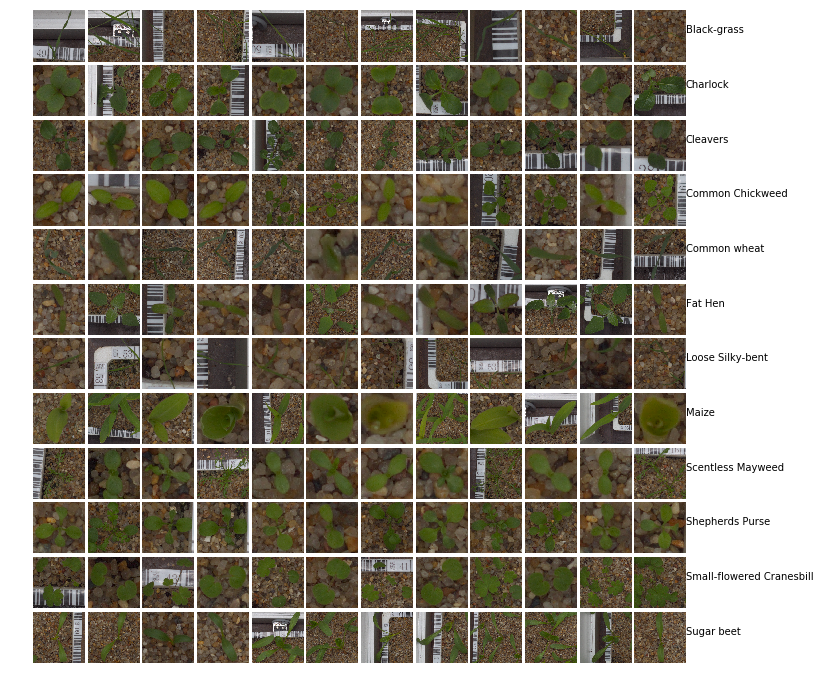

In [8]:
fig = plt.figure(1, figsize=(Category.shape[0], Category.shape[0]))
grid = ImageGrid(fig, 111, nrows_ncols=(Category.shape[0], Category.shape[0]), axes_pad=0.05)
i = 0
for category_id, category in enumerate(Category):
    for filepath in train[train['category'] == category]['file'].values[:Category.shape[0]]:
        ax = grid[i]
        imag = image.load_img(os.path.join(train_dir,filepath),target_size=(299,299))
        imag = image.img_to_array(imag)

        ax.imshow(imag / 255.)
        ax.axis('off')
        if i % Category.shape[0] == Category.shape[0] - 1:
            ax.text(300, 112, filepath.split('/')[0], verticalalignment='center')
        i += 1
plt.show();

# Plotting Histogram

In [9]:
labels = []
for c in Category:
    l = [c]*len(os.listdir(train_dir+ '/'+ c+'/'))
    labels.extend(l)

In [10]:
features = []
for i,image_path in enumerate(train.iloc[:,0]):
    image = cv2.imread(os.path.join(train_dir,image_path))

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    
    cv2.normalize(hist,hist)
    hist = hist.flatten()
    features.append(hist)
    if(i%1000==0):
        print(str(i)+ "  completed")

0  completed
1000  completed
2000  completed
3000  completed
4000  completed


In [11]:
from scipy.spatial import distance

In [ ]:
query = features[0]
distances  = []
for i in features[1:]:
    m = distance.euclidean(query,i)
    distances.append(m)

In [ ]:
index = distances.index(min(distances))

In [ ]:
result= cv2.imread(os.path.join(train_dir,train.iloc[index,0]))

In [ ]:
fig = plt.figure()
a = fig.add_subplot(1,2,1)
plt.imshow(cv2.imread(os.path.join(train_dir,train.iloc[0,0])))
plt.title("Query")
plt.xlabel(labels[0])
b = fig.add_subplot(1,2,2)
plt.imshow(cv2.imread(os.path.join(train_dir,train.iloc[index,0])))
plt.title("result")
plt.xlabel(labels[index])

In [ ]:
img = cv2.imread(os.path.join(train_dir,train.iloc[0,0]))
fig = plt.figure()
a = fig.add_subplot(1,2,1)
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
    plt.title("Query")
img2 = cv2.imread(os.path.join(train_dir,train.iloc[index,0]))
b = fig.add_subplot(1,2,2)
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
    plt.title("Result")

plt.show()

# Total Number of the Samples of Each Species of Plants

In [15]:
uniq, count = np.unique(train['label'], return_counts=True)
uniq = [Category[c] for c in uniq]
uniq_data = np.c_[uniq,count]
uniq_data = pd.DataFrame(uniq_data,columns=['Labels','Count'])
lowest_num_of_samples = min(count)
uniq_data.head(12)

,Labels,Count
0,Black-grass,263
1,Charlock,390
2,Cleavers,287
3,Common Chickweed,611
4,Common wheat,221
5,Fat Hen,475
6,Loose Silky-bent,654
7,Maize,221
8,Scentless Mayweed,516
9,Shepherds Purse,231


# loading model for resnet

In [17]:
i = 0 
m = 0
X_train = np.zeros((221*12,100,100,3))
labels = np.zeros((221*12),dtype=np.int)
for cat in tqdm(Category):
    c = 0
    for file in os.listdir(os.path.join(train_dir, cat)):
        imag = image.load_img(os.path.join(train_dir,cat, file),target_size=(100,100))
        imag = image.img_to_array(imag)
        c += 1
        if c <= lowest_num_of_samples:
            X_train[m] = imag/255.0
            labels[m] = i
            m +=1
    i += 1

100%|██████████| 12/12 [00:54<00:00,  4.55s/it]


In [18]:
X_train,labels = shuffle(X_train,labels,random_state = 0)

In [19]:
X_train, X_Val, Y_train, Y_Val = train_test_split(X_train, labels, test_size=0.1, random_state=1)

In [20]:
Y_train = np.eye(12)[Y_train]
# Y_train = np.eye(12)[Y_train]

# Creating RESNET from scratch

In [21]:
def identity_block(X, f, filters, stage, block):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    F1, F2, F3 = filters
    X_shortcut = X
    
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = 'same' , name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3 , name = bn_name_base + '2c')(X)

    X = Add()([X_shortcut , X])
    X = Activation('relu')(X)
    
    
    return X

In [22]:
def convolutional_block(X, f, filters, stage, block, s = 2):

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    F1, F2, F3 = filters
    
    X_shortcut = X
    
    X = Conv2D(F1, (1, 1), strides = (s, s), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    

    X = Conv2D(F2, (f, f), strides = (1, 1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3 , name = bn_name_base + '2b')(X)
    X = Activation("relu")(X)

    X = Conv2D(F3, (1, 1), strides = (1, 1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3 , name = bn_name_base + '2c')(X)

    X_shortcut = Conv2D(F3, (1, 1), strides = (s, s), padding = 'valid' , name = conv_name_base + '1' , kernel_initializer = glorot_uniform(seed = 0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3 , name = bn_name_base + '1')(X_shortcut)

    X = Add()([X_shortcut , X])
    X = Activation('relu')(X)
    
    
    return X

In [23]:
def ResNet50(input_shape, classes):
    
    X_input = Input(input_shape)

    
    X = ZeroPadding2D((3, 3))(X_input)
    
    X = Conv2D(28, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f = 3, filters = [28, 28, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [28, 28, 256], stage=2, block='b')
    X = identity_block(X, 3, [28, 28, 256], stage=2, block='c')

    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')
    
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [24]:
model = ResNet50(input_shape = (100, 100, 3), classes = 12)

In [25]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(X_train, Y_train, epochs = 25, batch_size = 64,shuffle= True)

Epoch 1/25
2386/2386 [==============================] - 16s 7ms/step - loss: 1.2743 - acc: 0.7431
Epoch 2/25
2386/2386 [==============================] - 16s 7ms/step - loss: 0.5543 - acc: 0.8818
Epoch 3/25
2386/2386 [==============================] - 16s 7ms/step - loss: 0.4047 - acc: 0.9220
Epoch 4/25
2386/2386 [==============================] - 16s 7ms/step - loss: 0.5541 - acc: 0.8847
Epoch 5/25
2386/2386 [==============================] - 16s 7ms/step - loss: 0.4612 - acc: 0.9191
Epoch 6/25
2386/2386 [==============================] - 16s 7ms/step - loss: 0.3719 - acc: 0.9468
Epoch 7/25
2386/2386 [==============================] - 16s 7ms/step - loss: 0.3125 - acc: 0.9514
Epoch 8/25
2386/2386 [==============================] - 16s 7ms/step - loss: 0.2522 - acc: 0.9665
Epoch 9/25
2386/2386 [==============================] - 16s 7ms/step - loss: 0.2408 - acc: 0.9732
Epoch 10/25
2386/2386 [==============================] - 16s 7ms/step - loss: 0.2086 - acc: 0.9761
Epoch 11/25
2386/23

In [ ]:
Y_pred = model.predict(X_Val)
Y_pred = np.argmax(Y_pred, axis = 1)

In [ ]:
# Y_val = np.argmax(Y_Val, axis = 1)
f1score = f1_score(Y_Val, Y_pred,average='micro')
print('The F1score on the Validation set is {}'.format(f1score))

In [ ]:
annotate = ['BG', 'Ch', 'Cl', 'CC', 'CW', 'FH', 'LSB', 'M', 'SM', 'SP', 'SFC', 'SB']

In [31]:
Confusion_mat = confusion_matrix(Y_Val,Y_pred)

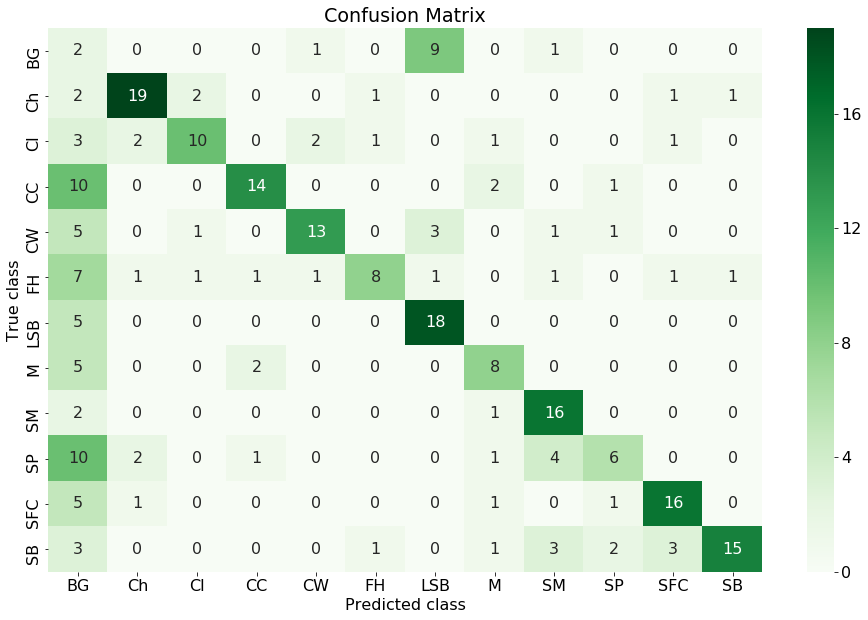

In [33]:
fig, ax = plt.subplots(1)
ax = sns.heatmap(Confusion_mat, ax=ax, cmap=plt.cm.Greens, annot=True,)
ax.set_xticklabels(annotate)
ax.set_yticklabels(annotate)
plt.title('Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show();

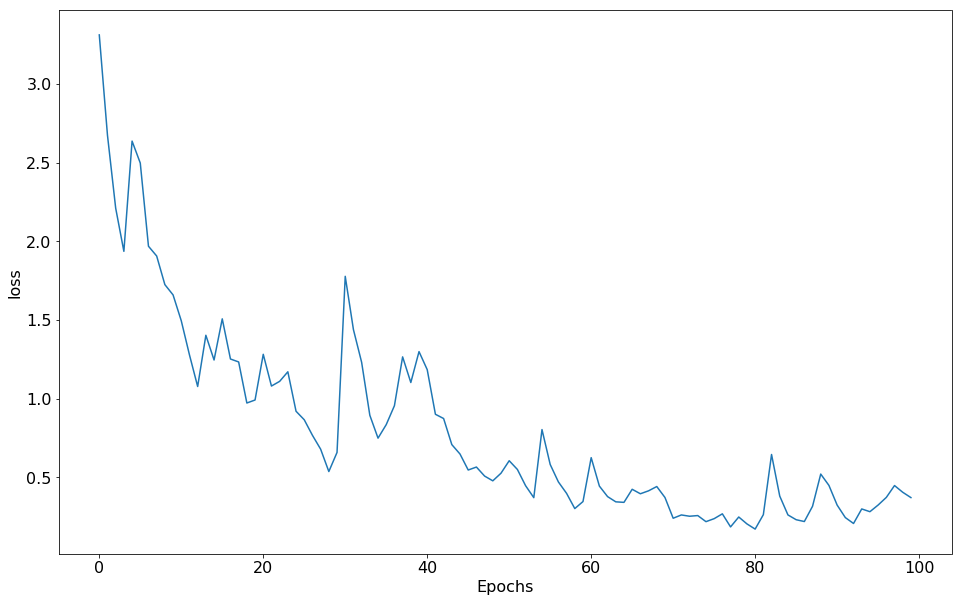

In [47]:
plt.plot(np.arange(0,100,1),model.history.history['loss'],label= 'train')
# plt.plot(np.arange(0,100,1),model.history.history['val_loss'],label = 'val')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.show()

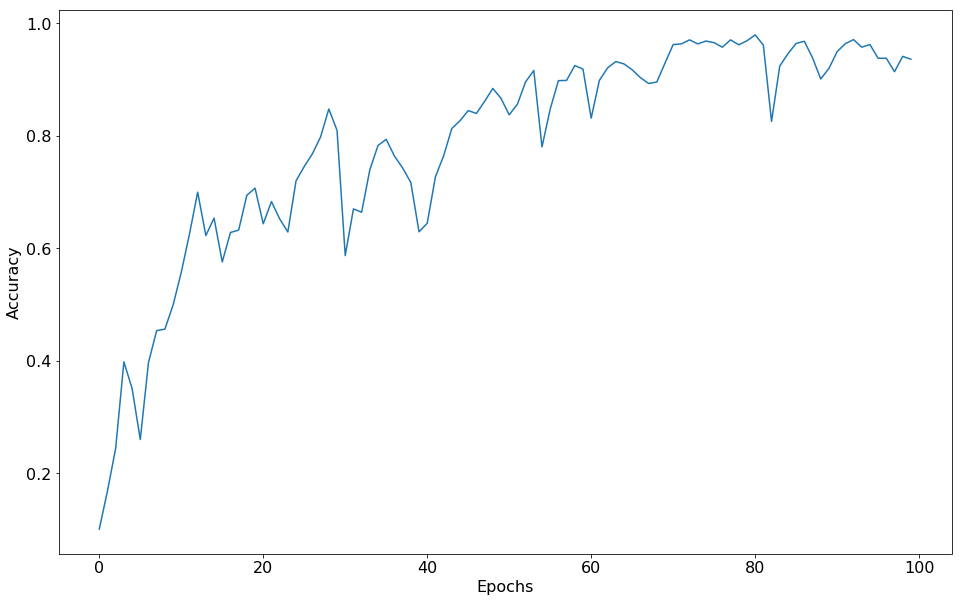

In [50]:
plt.plot(np.arange(0,100,1),model.history.history['acc'],label = 'train')
# plt.plot(np.arange(0,20,1),hist.history.history['val_acc'],label = 'val')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Loading Dataset.
**For each Class Loading the lowest number of samples the a species has and resizing all the image to the same size and Pre proccesing  images  for the Xception model.**

In [ ]:
i = 0 
m = 0
X_train = np.zeros((221*12,299,299,3))
labels = np.zeros((221*12),dtype=np.int)
for cat in tqdm(Category):
    c = 0
    for file in os.listdir(os.path.join(train_dir, cat)):
        imag = image.load_img(os.path.join(train_dir,cat, file),target_size=(299,299))
        imag = image.img_to_array(imag)
        imag = xception.preprocess_input(np.expand_dims(imag.copy(), axis=0))
        c += 1
        if c <= lowest_num_of_samples:
            X_train[m] = imag
            labels[m] = i
            m +=1
    i += 1

# Checking if the number of samples in the for each class is Lowest(221)

In [ ]:
uniq, count = np.unique(labels, return_counts=True)
uniq = [Category[c] for c in uniq]
uniq_data = np.c_[uniq,count]
uniq_data = pd.DataFrame(uniq_data,columns=['Labels','Count'])
uniq_data.head(12)

# Shuffling Data

In [ ]:
X_train,labels = shuffle(X_train,labels,random_state = 0)

# Spliting Data into Training  and Validation sets

In [ ]:
X_train, X_Val, Y_train, Y_Val = train_test_split(X_train, labels, test_size=0.1, random_state=1)

# Getting features from the Xception Model
**Load weights of Xception Model**

In [ ]:
xception_model = xception.Xception(weights='../input/keras-pretrained-models/xception_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, pooling='avg')
X_train = xception_model.predict(X_train,batch_size=32,verbose = 1)
X_Val = xception_model.predict(X_Val,batch_size=32,verbose = 1)

# Predict model on the SVC to set the Benchmark.

In [ ]:
model = SVC()
model.fit(X_train,Y_train)
train_pred = model.predict(X_train)
val_pred = model.predict(X_Val)
val_f1 = f1_score(Y_Val, val_pred,average='micro')    
print('Validation f1score Score :: {}'.format(val_f1))

# One Hot Encoding Training Labels.

In [ ]:
Y_train = np.eye(12)[Y_train]
Y_Val = np.eye(12)[Y_Val]

# Deep Neural Network

In [ ]:
new_model = Sequential()
new_model.add(Dense(1024, activation='relu', input_shape=(2048,)))
new_model.add(Dense(512, activation='relu'))
new_model.add(Dropout(rate=0.3))
new_model.add(Dense(256, activation='relu'))
new_model.add(Dense(128, activation='relu'))
new_model.add(Dropout(rate=0.3))
new_model.add(Dense(64, activation='relu'))
new_model.add(Dense(12, activation='softmax'))

In [ ]:
new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Run Deep Neural Network pn the training Set.

In [ ]:
hist = new_model.fit(X_train, Y_train, epochs = 20, batch_size = 64,validation_data=(X_Val,Y_Val))

# Predicting model on Validation Set

In [ ]:
Y_pred = new_model.predict(X_Val)
Y_pred = np.argmax(Y_pred, axis = 1)

In [ ]:
Y_val = np.argmax(Y_Val, axis = 1)
f1score = f1_score(Y_val, Y_pred,average='micro')
print('The F1score on the Validation set is {}'.format(f1score))

In [ ]:
annotate = ['BG', 'Ch', 'Cl', 'CC', 'CW', 'FH', 'LSB', 'M', 'SM', 'SP', 'SFC', 'SB']

In [ ]:
Confusion_mat = confusion_matrix(Y_Val,Y_pred)

In [ ]:
fig, ax = plt.subplots(1)
ax = sns.heatmap(Confusion_mat, ax=ax, cmap=plt.cm.Greens, annot=True,)
ax.set_xticklabels(annotate)
ax.set_yticklabels(annotate)
plt.title('Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show();

In [ ]:
plt.plot(np.arange(0,20,1),hist.history['loss'],label= 'train')
plt.plot(np.arange(0,20,1),hist.history['val_loss'],label = 'val')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
plt.plot(np.arange(0,20,1),hist.history['acc'],label = 'train')
plt.plot(np.arange(0,20,1),hist.history['val_acc'],label = 'val')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [52]:
i = 0 
m = 0
test = []
X_test = np.zeros((794,100,100,3))
for file in tqdm(os.listdir(os.path.join(test_dir))):
    imag = image.load_img(os.path.join(test_dir,file),target_size=(100,100))
    imag = image.img_to_array(imag)
#     imag = xception.preprocess_input(np.expand_dims(imag.copy(), axis=0))
    test.append(file)
    X_test[m] = imag/255.0
    m +=1

100%|██████████| 794/794 [00:03<00:00, 200.73it/s]


In [ ]:
X_test = xception_model.predict(X_test,batch_size=32,verbose = 1)

In [53]:
Y_pred = model.predict(X_test)
Y_pred = np.argmax(Y_pred, axis = 1)

In [54]:
test = pd.DataFrame(test,columns=['file'])
test['species'] = [Category[c] for c in Y_pred]
test[['file', 'species']].to_csv('submission.csv', index=False)

In [55]:
from IPython.display import HTML
import base64
def create_download_link( df, title = "Download CSV file", filename = "Plant_Seeds.csv"):  
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

create_download_link(test)